In [1]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
driver = webdriver.Chrome('C:/Users/Vrinda Sharma/Anaconda3/Scripts/chromedriver')
driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p720')


In [4]:
#Creating empty data frame to store user_id, dates and comments from ~5K users.
comments = pd.DataFrame(columns = ['Date','user_id','comments'])

j = 720
while (j>=1):
    # Running while loop only till we get 5K comments 
    if (len(comments)<5000):
        url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(j)
        driver.get(url)
        ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
        comment_ids = []
        for i in ids:
            comment_ids.append(i.get_attribute('id'))

        for x in comment_ids:
            #Extract dates from for each user on a page
            user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
            date = user_date.get_attribute('title')

            #Extract user ids from each user on a page
            userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
            userid = userid_element.text
            
           
            #Extract Message for each user on a page
            user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
            comment = user_message.text
            
            #Extracting Block Quote if Present
            block_quote = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
            block_quote_class = block_quote.find_elements_by_class_name('UserQuote')
            block_text = ''
            if len(block_quote_class)>0:
                block_text = block_quote_class[0].text
            
            #Replacing block quotes
            comment = comment.replace(block_text,"")
            
           #Adding date, userid and comment for each user in a dataframe    
            comments.loc[len(comments)] = [date,userid,comment]
        j=j-1
    else:
        break        

In [5]:
import copy
copy_comments = copy.deepcopy(comments)

def delete_space(s):
    return s.replace("\n"," ")

copy_comments['comments'] = copy_comments['comments'].apply(delete_space)
copy_comments.to_csv('edmund_comments.csv', header=True, sep=',') 

In [6]:
copy_comments = pd.read_csv('edmund_comments.csv')
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')
copy_comments = copy_comments.dropna()
copy_comments.reset_index(inplace  = True)

In [7]:
def remove_punctuation(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item

def conv_lowercase(x):
    return x.lower()

copy_comments['comments_clean'] = copy_comments['comments'].apply(remove_punctuation).apply(conv_lowercase)
models['brand'] = models['brand'].apply(remove_punctuation)

In [8]:
def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
copy_comments['model_to_brand'] = copy_comments['comments_clean'].apply(model_to_brand)

In [9]:
copy_comments.head()

,index,Unnamed: 0,Date,user_id,comments,comments_clean,model_to_brand
0,0,0,"April 24, 2019 2:23AM",qbrozen,"Used them all the time in my 135, CTS, and Ste...",used them all the time in my 135 cts and stelv...,used them all the time in my 135 cts and stelv...
1,1,1,"April 24, 2019 10:38PM",andres3,If' I had paddle shifters that didn't shift im...,if i had paddle shifters that didnt shift imme...,if i had paddle shifters that didnt shift imme...
2,2,2,"April 24, 2019 10:39PM",andres3,Lighting quick gear changes probably help con...,lighting quick gear changes probably help cont...,lighting quick gear changes probably help cont...
3,3,3,"April 24, 2019 11:42PM",henryn,"Anecdotal evidence is just that, anecdotal. A...",anecdotal evidence is just that anecdotal and ...,anecdotal evidence is just that anecdotal and ...
4,4,4,"April 25, 2019 3:33PM",andres3,"Well, I think the ""satisfaction"" rating for A...",well i think the satisfaction rating for a3 ow...,well i think the satisfaction rating for audi ...


In [10]:
copy_comments['tokenize_comments'] = copy_comments['model_to_brand'].apply(word_tokenize).apply(set).apply(list)

# Remove stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
copy_comments['final_list'] =  copy_comments['tokenize_comments'].apply(remove_stopwords)
#filtered_sentence = [w for w in temp['tokenize_comments'] if not w in stop_words]

In [11]:
# Creating a list of all the words in the comments to count word frequency in the next step

count = []
for i in range(len(copy_comments)):
    count+=copy_comments['final_list'][i]
    
count

['guess',
 'type',
 'never',
 'used',
 'stelvio',
 'economy',
 'driving',
 'cts',
 'fuel',
 'almost',
 'time',
 'lately',
 '135',
 '’',
 '330',
 'didnt',
 'next',
 '2006',
 'sold',
 'shift',
 'owner',
 'throw',
 'immediately',
 'clutch',
 '106000',
 'puppy',
 'paddleshifted',
 'paddle',
 'miles',
 'shifters',
 'audi',
 'buy',
 '150k',
 '06',
 'car',
 'mastered',
 'cvt',
 'took',
 'cliff',
 'dual',
 'dont',
 'id',
 'thankfully',
 'superior',
 'fuel',
 'changes',
 'lighting',
 'help',
 'contribute',
 'gear',
 'though',
 'quick',
 'probably',
 'economy',
 'owners',
 'none',
 'even',
 'wouldnt',
 'clutch',
 'still',
 'wanted',
 'evidence',
 'experience',
 'driving',
 'anecdotal',
 'mean',
 'really',
 'mastered',
 'couldnt',
 'dual',
 'blew',
 'expected',
 'say',
 'dsg',
 'reviews',
 'feel',
 'high',
 'mixed',
 'calibrated',
 'owners',
 'opinion',
 'would',
 'theres',
 'yes',
 'well',
 'call',
 'rating',
 'note',
 'something',
 'must',
 'like',
 'think',
 'done',
 'audi',
 'manual',
 'autom

In [12]:
# fetching the frequency of words
from nltk import FreqDist
word_freq = nltk.FreqDist(count)
word_freq

FreqDist({'car': 1917, 'like': 1180, 'one': 1079, 'bmw': 1052, 'would': 1046, 'get': 907, 'think': 859, 'new': 859, 'audi': 794, 'dont': 756, ...})

In [38]:
# fetching unique brands
brands_unique = models['brand'].drop_duplicates().tolist()
brands_unique

['acura',
 'audi',
 'bmw',
 'buick',
 'cadillac',
 'car',
 'chevrolet',
 'chrysler',
 'dodge',
 'ford',
 'honda',
 'hyndai kia',
 'hyundai',
 'infiniti',
 'kia',
 'lincoln',
 'mazda',
 'mercedes',
 'mercedes benz',
 'mercedesbenz',
 'mercury',
 'mitsubishi',
 'nissan',
 'pontiac',
 'problem',
 'saturn',
 'seat',
 'sedan',
 'subaru',
 'suzuki',
 'toyata',
 'toyota',
 'volkswagen',
 'volkwagen',
 'volvo']

In [39]:
top_words = word_freq.most_common(500)
top_brands = []
for (key, items) in top_words:
    if key in brands_unique:
        brand_count = (key,items)
        top_brands.append(brand_count)   
        
top_brands

[('car', 1917),
 ('bmw', 1052),
 ('audi', 794),
 ('acura', 491),
 ('honda', 430),
 ('seat', 274),
 ('sedan', 248),
 ('volkswagen', 247),
 ('problem', 217),
 ('cadillac', 207),
 ('mercedesbenz', 193),
 ('toyota', 191),
 ('hyundai', 186),
 ('infiniti', 182),
 ('ford', 178),
 ('volvo', 134),
 ('chevrolet', 120),
 ('kia', 109),
 ('subaru', 96),
 ('buick', 85),
 ('mazda', 80)]

In [46]:
top_10_brands_count = top_brands[:14]
print ('Below list contains the top 10 brands along with their frequencies\n' , top_10_brands_count[:14])
#there are a few entries on top that are not brands and hence we can discard those values e.g. car, sedan, problem, seat
#so the final top 10 brands are given as :
top_10_brands_list=[]
for i in range(len(top_10_brands_count)):
    if(top_10_brands_count[i][0] not in ['car','sedan','seat','problem']):
        top_10_brands_list.append(top_10_brands_count[i][0])
   
    
print('\n\nFinal list of top 10 brands -\n ',top_10_brands_list);


Below list contains the top 10 brands along with their frequencies
 [('car', 1917), ('bmw', 1052), ('audi', 794), ('acura', 491), ('honda', 430), ('seat', 274), ('sedan', 248), ('volkswagen', 247), ('problem', 217), ('cadillac', 207), ('mercedesbenz', 193), ('toyota', 191), ('hyundai', 186), ('infiniti', 182)]


Final list of top 10 brands -
  ['bmw', 'audi', 'acura', 'honda', 'volkswagen', 'cadillac', 'mercedesbenz', 'toyota', 'hyundai', 'infiniti']


### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 


In [54]:
# the top 10 brands.
  
    
top_10_brands_list

['bmw',
 'audi',
 'acura',
 'honda',
 'volkswagen',
 'cadillac',
 'mercedesbenz',
 'toyota',
 'hyundai',
 'infiniti']

In [56]:
df = pd.DataFrame(columns = top_10_brands_list)

def brand_mentioned(item):
    if brand in item:
        return 1
    else:
        return 0
      
for brand in top_10_brands_list:
    df[brand] = copy_comments['final_list'].apply(brand_mentioned)    

In [58]:
df.head()

,bmw,audi,acura,honda,volkswagen,cadillac,mercedesbenz,toyota,hyundai,infiniti
0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [61]:
# Calculating lift among top brands
df2=pd.DataFrame(columns = top_10_brands_list)
for i in range(len(top_10_brands_list)):
    new_list = []
    for j in range(len(top_10_brands_list)):
        if (i!=j):
            numerator = ((df[top_10_brands_list[i]] + df[top_10_brands_list[j]]) > 1).sum()
            denominator = df[top_10_brands_list[j]].sum()*df[top_10_brands_list[i]].sum()
            lift = numerator*len(df)/denominator
            df2.loc[top_10_brands_list[i],top_10_brands_list[j]] = lift
print ('Below are the lift ratios among top brands\n')
df2

Below are the lift ratios among top brands



,bmw,audi,acura,honda,volkswagen,cadillac,mercedesbenz,toyota,hyundai,infiniti
bmw,NaN,1.91765,1.50705,1.12517,1.24825,2.06232,3.41619,1.53972,1.4281,2.31955
audi,1.91765,NaN,2.29114,1.84154,2.67161,3.09678,3.77729,1.97423,1.79078,3.24591
acura,1.50705,2.29114,NaN,3.63975,1.31666,2.99487,3.47541,1.70269,1.8031,4.96979
honda,1.12517,1.84154,3.63975,NaN,2.02024,1.68183,1.80383,3.58468,2.24606,2.35919
volkswagen,1.24825,2.67161,1.31666,2.02024,NaN,1.36635,2.09352,2.32698,1.95507,2.22005
cadillac,2.06232,3.09678,2.99487,1.68183,1.36635,NaN,6.61986,2.01937,2.46247,4.90073
mercedesbenz,3.41619,3.77729,3.47541,1.80383,2.09352,6.61986,NaN,2.57196,3.19711,5.82446
toyota,1.53972,1.97423,1.70269,3.58468,2.32698,2.01937,2.57196,NaN,3.93289,2.7274
hyundai,1.4281,1.79078,1.8031,2.24606,1.95507,2.46247,3.19711,3.93289,NaN,3.09553
infiniti,2.31955,3.24591,4.96979,2.35919,2.22005,4.90073,5.82446,2.7274,3.09553,NaN


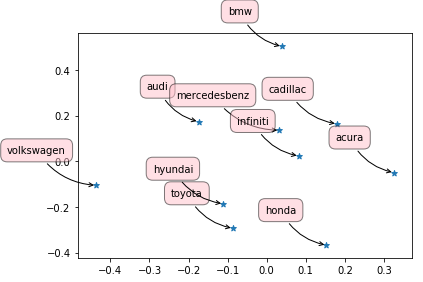

In [83]:
# Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/df2
np.fill_diagonal(dissimilarity_matrix.values, 0)

# Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = '*'
    )
for label, x, y in zip(top_10_brands_list, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-30, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.65', fc = 'pink', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.25'))

plt.show()